In [1]:
import pathlib
import regex

import numpy as np
import pandas as pd
from plotnine import *
import scipy.stats
import tqdm
import xswap.prior

In [2]:
full_prior_root = pathlib.Path('full_priors/')
full_prior_paths = sorted(full_prior_root.glob('*.tsv.gz'))

# full_prior_paths = [f'full_priors/{metaedge}.tsv.gz' for metaedge in ['AlD', 'G<rG']]

In [3]:
full_prior_paths

[PosixPath('full_priors/AdG.tsv.gz'),
 PosixPath('full_priors/AeG.tsv.gz'),
 PosixPath('full_priors/AlD.tsv.gz'),
 PosixPath('full_priors/AuG.tsv.gz'),
 PosixPath('full_priors/BPpG.tsv.gz'),
 PosixPath('full_priors/CCpG.tsv.gz'),
 PosixPath('full_priors/CbG.tsv.gz'),
 PosixPath('full_priors/CcSE.tsv.gz'),
 PosixPath('full_priors/CdG.tsv.gz'),
 PosixPath('full_priors/CrC.tsv.gz'),
 PosixPath('full_priors/CuG.tsv.gz'),
 PosixPath('full_priors/DaG.tsv.gz'),
 PosixPath('full_priors/DdG.tsv.gz'),
 PosixPath('full_priors/DpS.tsv.gz'),
 PosixPath('full_priors/DuG.tsv.gz'),
 PosixPath('full_priors/G<rG.tsv.gz'),
 PosixPath('full_priors/GcG.tsv.gz'),
 PosixPath('full_priors/GiG.tsv.gz'),
 PosixPath('full_priors/GpMF.tsv.gz'),
 PosixPath('full_priors/GpPW.tsv.gz')]

In [4]:
def compute_single_feature_calibration(dataframe, feature, num_bins):
    return (
        dataframe
        .assign(
            bin_number = lambda df: pd.qcut(df[feature], num_bins, labels=False, duplicates='drop')
                                    .astype(np.uint16)
        )
        .groupby('bin_number', as_index=False)
        .agg({feature: 'mean', 'edge': ['count', 'sum']})
        .drop('bin_number', axis=1, level=0)
        .assign(
            expected_frac = lambda df: ((df[('edge', 'sum')] + 1/2) / (df[('edge', 'count')] + 1))
                                        .astype(np.float32),
            lower_ci = lambda df: (scipy.stats.beta.ppf(0.025, df[('edge', 'sum')] + 1/2, 
                                                        df[('edge', 'count')] - df[('edge', 'sum')] + 1/2)
                                  ).astype(np.float32),
            upper_ci = lambda df: (scipy.stats.beta.ppf(0.975, df[('edge', 'sum')] + 1/2, 
                                                        df[('edge', 'count')] - df[('edge', 'sum')] + 1/2)
                                  ).astype(np.float32),
        )
        .assign(
            feature = feature,
            feature_value = lambda df: df[(feature, 'mean')]
        )
        .drop(['edge', feature], axis=1, level=0)
    )

In [5]:
full_calibration_df = pd.DataFrame()
for prior_path in tqdm.tqdm_notebook(full_prior_paths):
    metaedge = regex.search('(?<=full_priors/).+(?=.tsv.gz)', str(prior_path)).group()
    print(metaedge, flush=True)
    
    metaedge_calibration = pd.DataFrame()
    
    # Compute calibration of XSwap prior
    xswap_prior_df = pd.read_csv(prior_path, sep='\t', usecols=['edge', 'xswap_prior'])
    xswap_cal_df = compute_single_feature_calibration(xswap_prior_df, 'xswap_prior', 100)
    del xswap_prior_df
    
    metaedge_calibration = pd.concat([metaedge_calibration, xswap_cal_df])
    del xswap_cal_df
#     print('Computed XSwap calibration')
     
    # Compute calibration of scaled degree
    scaled_degree_df = pd.read_csv(prior_path, sep='\t', usecols=['edge', 'source_degree', 'target_degree'])
    degree_product = scaled_degree_df['source_degree'] * scaled_degree_df['target_degree']
    del scaled_degree_df['source_degree'], scaled_degree_df['target_degree']
    scaled_degree_df['scaled_degree'] = degree_product / degree_product.max()
    del degree_product
        
    scaled_degree_cal_df = compute_single_feature_calibration(scaled_degree_df, 'scaled_degree', 100)
    del scaled_degree_df
    
    metaedge_calibration = pd.concat([metaedge_calibration, scaled_degree_cal_df])
    del scaled_degree_cal_df
#     print('Computed scaled_degree calibration')
    
    # Compute calibration of analytic prior
    analytic_prior_df = (
        pd.read_csv(prior_path, sep='\t', usecols=['edge', 'source_degree', 'target_degree'])
        .assign(analytic_prior = lambda df: xswap.prior.approximate_xswap_prior(df['source_degree'],
                                                                                df['target_degree'],
                                                                                df['edge'].sum()))
        .drop(['source_degree', 'target_degree'], axis=1)
    )
    analytic_prior_cal_df = compute_single_feature_calibration(analytic_prior_df, 'analytic_prior', 100)
    del analytic_prior_df
    
    metaedge_calibration = pd.concat([metaedge_calibration, analytic_prior_cal_df]).assign(metaedge=metaedge)
    del analytic_prior_cal_df
#     print('Computed analytic_prior calibration')
    
    full_calibration_df = pd.concat([full_calibration_df, metaedge_calibration])
    
full_calibration_df.to_csv('hetionet_calibration_bins.csv', index=False)

full_calibration_df.head()

AdG
AeG
AlD
AuG
BPpG
CCpG
CbG
CcSE
CdG
CrC
CuG
DaG
DdG
DpS
DuG
G<rG
GcG
GiG
GpMF
GpPW



,expected_frac,lower_ci,upper_ci,feature,feature_value,metaedge
,,,,,,
0,0.000043,0.000038,0.000048,xswap_prior,0.000079,AdG
1,0.033288,0.032089,0.034509,xswap_prior,0.039669,AdG
2,0.067910,0.066210,0.069630,xswap_prior,0.075593,AdG
3,0.103440,0.101395,0.105502,xswap_prior,0.120118,AdG
4,0.184650,0.182030,0.187283,xswap_prior,0.181767,AdG


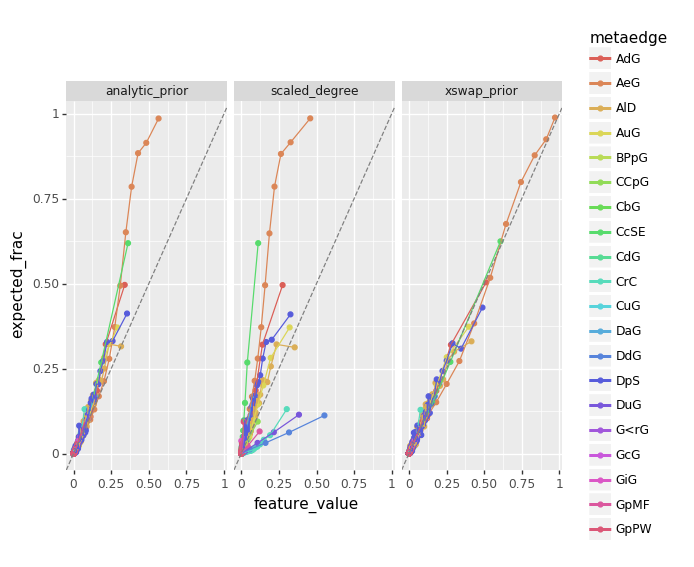

<ggplot: (-9223363302693529277)>

In [6]:
(
    ggplot(full_calibration_df, aes(x = 'feature_value', y = 'expected_frac', color = 'metaedge'))
    + geom_point()
    + geom_line()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap('feature')
)